<h1 align="center">Yelp Rating Prediction</h1>

In this Jupyter Notebook project, a suspected correlation is explored between the text content of a business' user reviews and the business' respective star rating. By applying natural language processing (NLP) to the text content of user reviews, a supervised machine learning model in [TensorFlow](https://www.tensorflow.org/) can be constructed to predict star ratings (i.e. $f(reviews)=star\ rating$). Despite discrete star rating values (e.g. $[1.0, 1.5, ..., 4.5, 5.0]$), a regression model is used here instead of classification since the star ratings are within a numerical range.

The dataset used for this project is sourced from the [Yelp Open Dataset](https://www.yelp.com/dataset), a public and non-commercial dataset for educational purposes.

<hr style="border-top: 2px solid #444">

## Development Environment
In this section, the development environment for this Jupyter notebook project is configured by collecting Python dependencies, importing libraries, and configuring the runtime environment.

### Python Dependencies
External Python dependencies are collected through the [Pipenv](https://pypi.org/project/pipenv/) package manager since it supports dependency lock-files. In the following script, `pipenv` and its transitive dependencies are installed from `pipenv-requirements.txt` and then the notebook's dependencies are installed from `Pipfile` and `Pipfile.lock`.

In [1]:
!pip install -r pipenv-requirements.txt
!pipenv install

### Python Imports
All relevant project libraries and utilities for the notebook are imported here.

In [2]:
from typing import TypedDict, Dict, List
from statistics import mean, stdev
from io import StringIO
from time import time
import sys
import os
import json
import spectra
import math
import pandas
import numpy
import sklearn
import tensorflow
import matplotlib.pyplot as pyplot
from matplotlib.ticker import FuncFormatter
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# store standard out stream
original_stdout = sys.stdout

print(f"Python: {sys.version}")
print(f"Pandas {pandas.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
print(f"Tensor Flow Version: {tensorflow.__version__} (Keras Version: {tensorflow.keras.__version__})")

Python: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Pandas 1.1.2
Scikit-Learn 0.23.2
Tensor Flow Version: 2.3.0 (Keras Version: 2.4.0)


### Configure PRNG Seed
Numpy, Tensorflow, and SciKit rely on [pseudorandom number generators](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) for internal operations. To guarantee deterministic behaviour and reproducible results when executing this notebook, an arbitrary seed is configured and used.

In [3]:
# arbitrary changeable seed constant
PRNG_SEED = 42

numpy.random.seed(PRNG_SEED)
tensorflow.random.set_seed(PRNG_SEED)

<hr style="border-top: 2px solid #444">

# I. Data Importation
The Yelp data needs to be imported from its JSON file format into usable in-memory data structures. Yelp provides documentation on their dataset file formats and structures [here](https://www.yelp.com/dataset/documentation/main).

## Dataset Location
For this project, all data is stored in the `data` folder in the repository root directory. Historically, Yelp has changed the file names a few times; thus, they are enumerated below at the time of implementing this project. A few path constants are set here and used later when importing the dataset.

In [4]:
!dir /b "./data/"

FILE_BUSINESSES = r"data/yelp_academic_dataset_business.json"
FILE_USER_REVIEWS = r"data/yelp_academic_dataset_review.json"

Dataset_User_Agreement.pdf
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


## Import Yelp Businesses
All public registered businesses are loaded from the new-line (e.g. `\n`) delimited JSON file and are indexed into a dictionary by their corresponding `business_id`. Of only particular interest, are the business' `business_id`, `review_count`, and `stars` attributes.

In [5]:
# metrics
start_time = time()

# business data structure
class Business(TypedDict):
    business_id: str
    review_count: int
    stars: float

# businesses indexed by business_id (i.e. {business['business_id']: Business}
businesses_by_id: Dict[str, Business] = {}

# parse all businesses
with open(FILE_BUSINESSES, 'r', encoding='utf-8') as file:
    # iterate over newline-delimited JSON records
    record: str
    for record in file:
        # parse JSON record
        business: Business = json.loads(record)
        # map Business by business_id
        businesses_by_id[business['business_id']] = business

# metrics
print(f"Imported {len(businesses_by_id):,} distinct businesses in {time() - start_time:.6f} seconds")

Imported 209,393 distinct businesses in 4.126696 seconds


## Import User Reviews
All public user reviews of businesses are loaded from the new-line (e.g. `\n`) delimited JSON file and are indexed into a dictionary array by matching `business_id`s. Of only particular interest, are the business' `business_id` and `text` attributes - no other data from user reviews is used.

In [6]:
# metrics
start_time = time()

# user review data structure
class UserReview(TypedDict):
    business_id: str
    text: str

# user reviews indexed by business_id (i.e. {business_id: UserReview['text'][]})
business_review_texts: Dict[str, List[str]] = {
    business_id: []
    for business_id in businesses_by_id.keys()
}

# parse user reviews
with open(FILE_USER_REVIEWS, 'r', encoding='utf-8') as file:
    # iterate over newline-delimited JSON records
    record: str
    for record in file:
        # parse JSON record
        review: UserReview = json.loads(record)
        # map user review by business_id
        business_review_texts[review['business_id']].append(review["text"])

# metrics
print(f"Imported {sum([len(reviews) for reviews in business_review_texts.values()]):,} user reviews in {time() - start_time:.6f} seconds")

Imported 8,021,122 user reviews in 96.604981 seconds


<hr style="border-top: 2px solid #444">

## II. Dataset Visualization

Before training the machine learning model, some of the business attributes should be explored better investigate the dataset and understand its distributions.

### Star Rating Distribution
The following graphic displays how discrete star ratings (i.e. $[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]$) for businesses on Yelp are distributed.

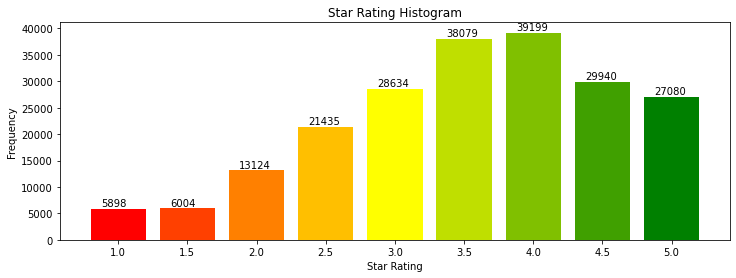

Rendered graphic in 0.559138 seconds


In [7]:
# metrics
start_time = time()

pyplot.figure(figsize=(12, 4))
pyplot.title("Star Rating Histogram")
pyplot.xlabel("Star Rating")
pyplot.ylabel("Frequency")
star_color = spectra.scale(['red', 'yellow', 'green'])
for star_rating, frequency in pandas.DataFrame(businesses_by_id.values(), columns=['stars'])['stars'].value_counts().sort_index().items():
    pyplot.bar(str(star_rating), frequency, color=star_color((star_rating - 1)/ 4).hexcode)
    pyplot.text(star_rating * 2 - 2.25, frequency + 400, frequency)
pyplot.show()

# metrics
print(f"Rendered graphic in {time() - start_time:.6f} seconds")

### Review Count Distribution
The following graphic displays a frequency count and cumulative distribution of review counts for businesses on Yelp.

It becomes quite obvious our dataset is skewed and that there might be dataset noise and significant biases at play when trying to find a correlation between user reviews and a business' star rating.

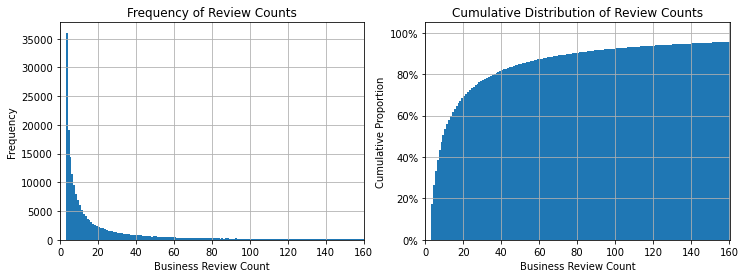

Rendered graphic in 39.499829 seconds


In [8]:
# metrics
start_time = time()

review_counts = [business['review_count'] for business in businesses_by_id.values()]
figure = pyplot.figure(figsize=(12, 4))

axes = figure.add_subplot(1, 2, 1)
axes.set_title("Frequency of Review Counts")
axes.set_xlabel("Business Review Count")
axes.axis(xmin=0, xmax=mean(review_counts) + stdev(review_counts))
axes.set_ylabel("Frequency")
axes.grid(True)
axes.hist(review_counts, bins = list(range(0, max(review_counts))))

axes = figure.add_subplot(1, 2, 2)
axes.set_title("Cumulative Distribution of Review Counts")
axes.set_xlabel("Business Review Count")
axes.axis(xmin=0, xmax=mean(review_counts) + stdev(review_counts))
axes.set_ylabel("Cumulative Proportion")
axes.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
axes.grid(True)
pyplot.hist(review_counts, bins=list(range(0, max(review_counts))), cumulative=True, density=True)

pyplot.show()

# metrics
print(f"Rendered graphic in {time() - start_time:.6f} seconds")

<hr style="border-top: 2px solid #444">

## III. Data Preprocessing
Before training a machine learning model, the raw text content has to be preprocessed into numerical matrices for TensorFlow. In the following subsections, the dataset is prepared for the machine learning model.

### Filter Businesses with Less than 15 Reviews
As seen in the visualization of star ratings, a significant amount of businesses do not have many user reviews. This is problematic, creating strong biases and word associations in user reviews on less-reviewed businesses. To mitigate bias and variance, a business must have a minimum threshold of 15 or more user reviews to be considered for the remainder of the project. The results should still be statistically significant, as close to half of all businesses have 15 or more reviews.

In [9]:
# minimum business['review_count'] required to be selected
MINIMUM_REVIEW_COUNT = 15

selected_businesses = [business for business in businesses_by_id.values() if MINIMUM_REVIEW_COUNT <= business['review_count']]

print(f"Selected {len(selected_businesses):,} businesses (filtered {len(businesses_by_id) - len(selected_businesses):,})")

Selected 80,355 businesses (filtered 129,038)


### Data Partitioning: Training, Validation, and Testing
It is rather computationally expensive to use the entire dataset; instead a subset of the selected businesses are split into 3 disjoint partitions:
- **training**: used for training the model
- **validation**: provides an evaluation of the model fit during training
- **testing**: provides an evaluation of the final fitted model

In [10]:
# partition size constants
TRAINING_SIZE = 25_000
VALIDATE_SIZE = 1_000
TESTING_SIZE = 10_000

# metrics
start_time = time()

# perform partitions; note: train_test_split does not support 3-way splitting
partitions = {}
partitions['train'], _ = train_test_split(
    # select all businesses that are greater than or equal to MINIMUM_REVIEW_COUNT
    selected_businesses,
    # partition proportions
    train_size=TRAINING_SIZE,
    shuffle=True,
    # PRNG seed for deterministic behaviour
    random_state=PRNG_SEED,
)
partitions['validate'], partitions['test'] = train_test_split(
    # select all businesses not in partitions['train']
    [
        businesses_by_id[business_id]
        for business_id in set([business['business_id'] for business in selected_businesses]).difference(set([business['business_id'] for business in partitions['train']]))
    ],
    # partition proportions
    train_size=VALIDATE_SIZE,
    test_size=TESTING_SIZE,
    shuffle=True,
    # PRNG seed for deterministic behaviour
    random_state=PRNG_SEED,
)

# metrics
print(f"Partitioned {len(businesses_by_id):,} businesses into { {category: len(partition) for category, partition in partitions.items()}} in {time() - start_time:.6f} seconds")
print(f"Remaining unused businesses: {len(businesses_by_id) - sum([len(partition) for partition in partitions.values()]):,}")

Partitioned 209,393 businesses into {'train': 25000, 'validate': 1000, 'test': 10000} in 0.336058 seconds
Remaining unused businesses: 173,393


### Input Features: Preprocess Review Texts using TF-IDF Vectorization
Natural language processing must be applied onto the user reviews to prepare the natural language input data into numerical matrices. Concatenated user reviews are vectorized into a [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighted word matrix.

An important note is that this operation mitigates bias by splitting the training, validation, and testing subsets prior to fitting the TF-IDF vectorization model. Training data is used to fit the model for vectorization features and is later transformed, while validation testing data is _only_ transformed by the model.

> **Note**: Increasing the `max_features` vectorizer parameter decreases the resulting RMSE score, but with diminishing returns.

In [11]:
# metrics
start_time = time()

# construct vectorizer
vectorizer: TfidfVectorizer = TfidfVectorizer(
    # maximum word features
    max_features=1000,
    # prune english stop words
    stop_words='english',
)

# construct corpus partitions
tf_input = {
    category: getattr(vectorizer, 'fit_transform' if category == 'train' else 'transform')
              (['\n'.join(business_review_texts[business['business_id']]) for business in partition])
              .toarray()
    for category, partition in partitions.items()
}

# metrics
print(f"Word features cardinality: {len(vectorizer.get_feature_names()):,}")
print(f"Word features: {vectorizer.get_feature_names()}")
print(f"IDF Vectorized {sum([len(matrix) for matrix in tf_input.values()]):,} businesses review texts in {time() - start_time:.6f} seconds")
print()
print(f"Training Shape: {tf_input['train'].shape}")
print(f"Validate Shape: {tf_input['validate'].shape}")
print(f"Testing Shape: {tf_input['test'].shape}")

Word features cardinality: 1,000
Word features: ['00', '10', '100', '11', '12', '15', '20', '24', '25', '30', '40', '45', '50', '99', 'able', 'absolutely', 'accommodating', 'actual', 'actually', 'add', 'added', 'addition', 'affordable', 'afternoon', 'ago', 'ahead', 'air', 'airport', 'amazing', 'ambiance', 'american', 'answer', 'apparently', 'appetizer', 'appetizers', 'appointment', 'appreciate', 'area', 'aren', 'arrived', 'asian', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado', 'avoid', 'away', 'awesome', 'awful', 'baby', 'bacon', 'bad', 'bag', 'baked', 'bar', 'barely', 'bartender', 'based', 'basic', 'basically', 'bathroom', 'bbq', 'beans', 'beautiful', 'bed', 'beef', 'beer', 'beers', 'believe', 'best', 'better', 'big', 'birthday', 'bit', 'bite', 'black', 'bland', 'blue', 'book', 'bottle', 'bought', 'bowl', 'box', 'boyfriend', 'bread', 'break', 'breakfast', 'bring', 'brisket', 'broth', 'brought', 'brun

### Output Features: Select Star Rating
The only output feature for our training model is a business' unnormalized star rating. Despite the discrete values for star ratings, regression is used here and the predicted result can be rounded to the nearest half star.

In [12]:
tf_output = {
    category: numpy.array([[business['stars']] for business in partition])
    for category, partition in partitions.items()
}

print(f"Training Shape: {tf_output['train'].shape}")
print(f"Validate Shape: {tf_output['validate'].shape}")
print(f"Testing Shape: {tf_output['test'].shape}")

Training Shape: (25000, 1)
Validate Shape: (1000, 1)
Testing Shape: (10000, 1)


<hr style="border-top: 2px solid #444">

# IV. Model Training
Using the defined input and output feature matrices, a neural network can be trained with a supervised learning regression model. Potentially, a correlation may be discovered between text reviews and the star rating.

## Build Model
A supervised learning Sequential neural network is constructed for building a regression model. A simple model with fully-connected dense layers is employed here.

In [13]:
# build model
model = Sequential(
    [
        Dense(64, input_dim=tf_input['train'].shape[1]),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ],
    name="yelp_regression"
)
# set optimizer for gradient descent
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

# print model summary
model.summary()

Model: "yelp_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                64064     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


## Train Model


In [14]:
# metrics
start_time = time()

# store standard out stream
original_stdout = sys.stdout
# replace standard out for intercepting model training logs
sys.stdout = captured_stdout = StringIO()

try:
    # make temporary directory for saved model
    if not os.path.exists("temp"):
        os.mkdir("temp")

    # perform model training
    model.fit(
        # training data
        tf_input['train'], tf_output['train'],
        # use test data to validate losses, but not for training
        validation_data=(tf_input['validate'], tf_output['validate']),
        callbacks=[
            # patience: number of epochs with no improvement after which training will be stopped
            EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, mode='auto', verbose=0),
            # save best model from all epochs
            ModelCheckpoint(filepath="temp/model_best_weights.hdf5", save_best_only=True, verbose=0)
        ],
        verbose=2,
        epochs=1000,
    )
finally:
    # restore standard out
    sys.stdout = original_stdout

# metrics
print(f"Model trained in {time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>Training Details</b></summary>\
        <sub><sup>\
            {"<br>".join(captured_stdout.getvalue().splitlines())}\
        </sup></sub>\
    </details>\
'))

Model trained in 210.069468 seconds


<hr style="border-top: 2px solid #444">

# V. Model Accuracy
The accuracy of the model can be quantified and visualized by comparing the predicted outputs with the actual expected outputs with the testing subset.

## Model Predictions
Using the testing subset, predicted star ratings can be quickly computed with our trained model and its weights. Model predictions are computed using the regression model as continuous values and then rounded to the nearest half star as discrete values.

In [15]:
# metrics
start_time = time()

# load best model for prediction
model.load_weights("temp/model_best_weights.hdf5")

# compute predicted ratings for test dataset
predicted = model.predict(tf_input['test'])
# map predictions to the nearest half-star
predicted_rounded = numpy.array([min(round(prediction * 2) / 2, 5) for prediction in predicted.flatten()])

# metrics
print(f"Predicted {len(tf_input['test']):,} business ratings in {time() - start_time:.6f} seconds")

Predicted 10,000 business ratings in 0.679747 seconds


## Error Scoring (MSE/RSME)
Our model's prediction accuracy can be quantified numerically with a [MSE or RMSE](https://en.wikipedia.org/wiki/RSME) score. The score is actually quite statistically significant - the deviation is within the realm of roughly a half star. The scores are shown below for continuous predictions and discrete half-star rounded predictions.

In [16]:
mse_score = sklearn.metrics.mean_squared_error(predicted, tf_output['test'])
mse_rounded_score = sklearn.metrics.mean_squared_error(predicted_rounded, tf_output['test'])

pandas.DataFrame(
    [
        [mse_score, mse_rounded_score],
        numpy.sqrt([mse_score, mse_rounded_score])
    ],
    columns=["Continuous", "Discrete"],
    index=["MSE", "RMSE"]
)

,Continuous,Discrete
MSE,0.079469,0.097575
RMSE,0.281903,0.312370


## Lift Chart Visualization
Quantified error scoring does not lend itself to be easily interpreted; instead, the results may be visualized using a lift chart visualization from our predictions and actual values. Arbitrary businesses are ordered by their actual star rating; the deviations from the predicted value are quickly visible from the actual expected values.

Interestingly enough, since a regression model was used here, continuous values above a 5 star rating are predicted. For the discrete visualization, values are clamped to only possible values for star ratings (i.e. clamped to `[0, 5]` and rounded to the nearest half-star).

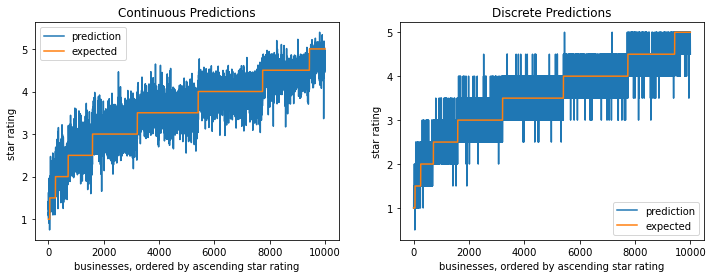

In [17]:
figure = pyplot.figure(figsize=(12, 4))

axes = figure.add_subplot(1, 2, 1)
axes.set_title("Continuous Predictions")
axes.set_xlabel("businesses, ordered by ascending star rating")
axes.set_ylabel("star rating ")
table = pandas.DataFrame({'predicted': predicted.flatten(), 'y': tf_output['test'].flatten()})
table.sort_values(by=['y'], inplace=True)
axes.plot(table['predicted'].tolist(), label="prediction")
axes.plot(table['y'].tolist(), label="expected")
axes.legend()

axes = figure.add_subplot(1, 2, 2)
axes.set_title("Discrete Predictions")
axes.set_xlabel("businesses, ordered by ascending star rating")
axes.set_ylabel("star rating")
table = pandas.DataFrame({'predicted': predicted_rounded.flatten(), 'y': tf_output['test'].flatten()})
table.sort_values(by=['y'], inplace=True)
axes.plot(table['predicted'].tolist(), label="prediction")
axes.plot(table['y'].tolist(), label="expected")
axes.legend()

pyplot.show()

<hr style="border-top: 2px solid #444">

# VI. Conclusion

If a business has enough reviews (in our case, 15), there is a surprisingly accurate correlation between the text content of the user reviews and the star rating the business receives. The discrete lift chart visualization shows most of the deviation of predicted values occurs within a half-star of the actual expected value.

The purpose of this project was not to optimize a model's ability to accurate predict stars, but to inspect a suspected correlation of data. It may be possible to construct a significantly better regression model using more input features of businesses (such as location, hours of operation, tips, etc), but optimization for this project is not quite necessary for identifying a correlation with a business's user reviews and its respective star rating.